# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [336]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics
import keras as ke
import glob

In [337]:
Hojas = []
for i in glob.glob("datos/precios/*"):
    Hojas.append(i)
Precios = pd.read_excel(Hojas[0], skiprows = 3)

In [338]:
for i in range(1,len(Hojas)):    
    aux = 0    
    while(True):         
        precio_i = pd.read_excel(Hojas[i],skiprows = aux).iloc[:,0:25]          
        if precio_i.columns[0] == 'Fecha':
            break
        else:
            aux+=1
    Precios = pd.concat([Precios, precio_i], ignore_index= True, axis=0)

In [339]:
Precios["Fecha"] = pd.to_datetime(Precios["Fecha"])
Precios = Precios.sort_values(by=["Fecha"])
Plot = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
Plot = Plot.dropna()
#plt.figure(num = None, figsize =(20,10))
#plt.plot(Plot["Fecha"], Plot.iloc[:,1], linewidth = 0.5)
#plt.show()

In [340]:
Plot = Plot.reset_index(drop=True)
Plot.columns = ["Fecha","Precio"]
Plot["Precio"]=(Plot["Precio"]-Plot["Precio"].min())/(Plot["Precio"].max()-Plot["Precio"].min())
#plt.figure(num = None, figsize =(20,10))
#plt.plot(Plot["Fecha"], Plot.iloc[:,1], linewidth = 0.5)
#plt.show()

In [341]:
tf.enable_eager_execution()

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [342]:
class Model(object):
    def __init__(self, L):
        self.w = tf.Variable([0.0] * (L))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

def SacarRetardo(Prueba,aux):  
    Retardos = []
    
    for i in range(len(Prueba)):
        L = Prueba[i]
        model = Model(L)
        y_pred = np.empty(len(aux))
        y_pred[:] = np.nan
        
        for t in range(L, len(aux)):
            x = aux[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=aux[t])
            
        Retardos.append([aux[-(24*7):],y_pred[-(24*7):]]) 
    return Retardos

def SacarTasa(Prueba2,Aux2):
    Tasas = []

    for i in range(len(Prueba2)):    
        L = 7
        model = Model(L)
        y_pred = np.empty(len(Aux2))
        y_pred[:] = np.nan

        for t in range(L, len(Aux2)):
            x = Aux2[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=Prueba2[i], x=x, y_desired=Aux2[t])

        Tasas.append([Aux2[-(24*7):],y_pred[-(24*7):]])
    return Tasas

def adaline(Ret,Tasa,d):
    Ret = Ret
    model = Model(Ret)
    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(Ret, len(d)):
        x = d[t-Ret:t]
        y_pred[t] = model(x)
        model.fit(mu=Tasa, x=x, y_desired=d[t])
    
    return [d[-(24*7):],y_pred[-(24*7):]]

def Graficar (Real, Pred):
    plt.figure(figsize=(23,7))
    plt.ylabel("Precio")
    plt.plot(Real, color="black", label="Real")
    plt.plot(Pred, color="red", label="Predicción")
    plt.xlabel('Horas/Día \n \n'+
              'MSE: '+str(metrics.mean_squared_error(Real, Pred)))
    plt.legend()
    plt.show()

In [343]:
aux = (Plot.iloc[:,1].values.reshape(-1,1)).reshape(-1,)
Prueba = [2,3,4,5,6,7,6,7,8,9,10,11]
Prueba2 = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]

In [344]:
RetardosTotal = SacarRetardo(Prueba,aux)
MejorRetardo = []
for i in RetardosTotal:
    MejorRetardo.append(metrics.mean_squared_error(i[0],i[1]))

In [345]:
A = MejorRetardo.index(min(MejorRetardo))
Ret= Prueba[A]

In [346]:
TasaTotal = SacarTasa(Prueba2,aux)
MejorTasa = []
for i in TasaTotal:
    MejorTasa.append(metrics.mean_squared_error(i[0],i[1]))

In [347]:
B = MejorTasa.index(min(MejorTasa))
Tasa = Prueba2[B]

In [348]:
Ada = adaline(Ret,Tasa,aux)

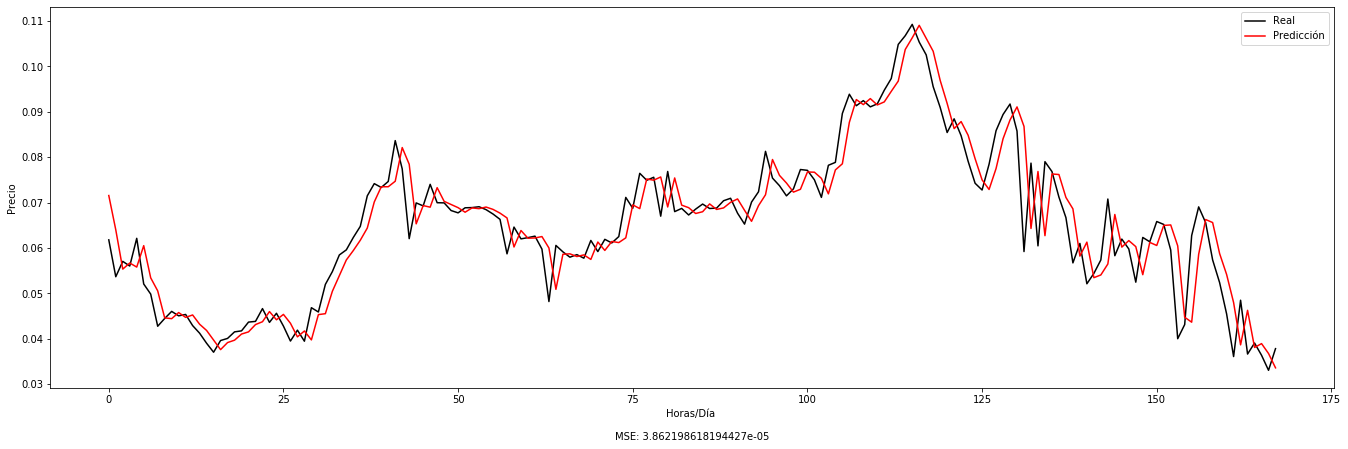

In [349]:
Graficar(Ada[0],Ada[1])

In [350]:
PlotRaiz = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
PlotRaiz = PlotRaiz.dropna()
PlotRaiz = PlotRaiz.reset_index(drop=True)
PlotRaiz.columns = ["Fecha","Precio"]
PlotRaiz["Precio"]=(PlotRaiz["Precio"].apply(np.sqrt))
PlotRaiz["Precio"]=(PlotRaiz["Precio"]-PlotRaiz["Precio"].min())/(PlotRaiz["Precio"].max()-PlotRaiz["Precio"].min())

In [351]:
Prueba = [2,3,4,5,6,7,6,8,9]
Prueba2 = [0.01,0.02,0.03,0.04,0.05,0.06,0.07]

In [352]:
RetardosRaiz = SacarRetardo(Prueba, PlotRaiz["Precio"].to_numpy())

In [353]:
MejorRetardoRaiz = []
for i in RetardosRaiz:
    MejorRetardoRaiz.append(metrics.mean_squared_error(i[0],i[1]))
A = MejorRetardoRaiz.index(min(MejorRetardoRaiz))
Ret= Prueba[A]

In [354]:
TasaRaiz = SacarTasa(Prueba2,PlotRaiz["Precio"].to_numpy())

In [355]:
MejorTasaRaiz = []
for i in TasaRaiz:
    MejorTasaRaiz.append(metrics.mean_squared_error(i[0],i[1]))
B = MejorTasa.index(min(MejorTasa))
Tasa = Prueba2[B]

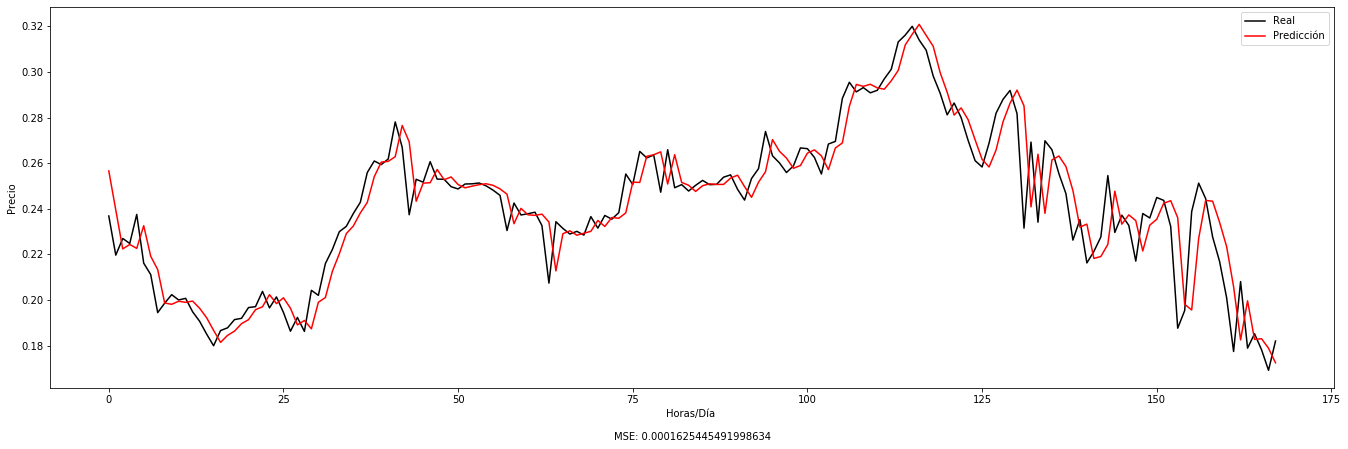

In [356]:
RaizAda = adaline(Ret,Tasa,PlotRaiz["Precio"].to_numpy())
Graficar(RaizAda[0],RaizAda[1])

In [357]:
PlotRaiz1 = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
PlotRaiz1 = PlotRaiz.dropna()
PlotRaiz1 = PlotRaiz.reset_index(drop=True)
PlotRaiz1.columns = ["Fecha","Precio"]
PlotRaiz1["Precio"]=(PlotRaiz["Precio"].apply(np.cbrt))
PlotRaiz1["Precio"]=(PlotRaiz["Precio"]-PlotRaiz["Precio"].min())/(PlotRaiz["Precio"].max()-PlotRaiz["Precio"].min())

In [365]:
Prueba1 = [2,3,4,5,6,7]
Prueba21 = [0.01,0.02,0.03,0.04,0.05,0.06]

In [366]:
RetardosRaiz1 = SacarRetardo(Prueba1, PlotRaiz1["Precio"].to_numpy())

In [368]:
MejorRetardoRaiz1 = []
for i in RetardosRaiz1:
    MejorRetardoRaiz1.append(metrics.mean_squared_error(i[0],i[1]))
A = MejorRetardoRaiz1.index(min(MejorRetardoRaiz1))
Ret= Prueba1[A]

In [369]:
TasaRaiz1 = SacarTasa(Prueba21,PlotRaiz1["Precio"].to_numpy())

In [370]:
MejorTasaRaiz1 = []
for i in TasaRaiz1:
    MejorTasaRaiz1.append(metrics.mean_squared_error(i[0],i[1]))
B = MejorTasaRaiz1.index(min(MejorTasaRaiz1))
Tasa = Prueba21[B]

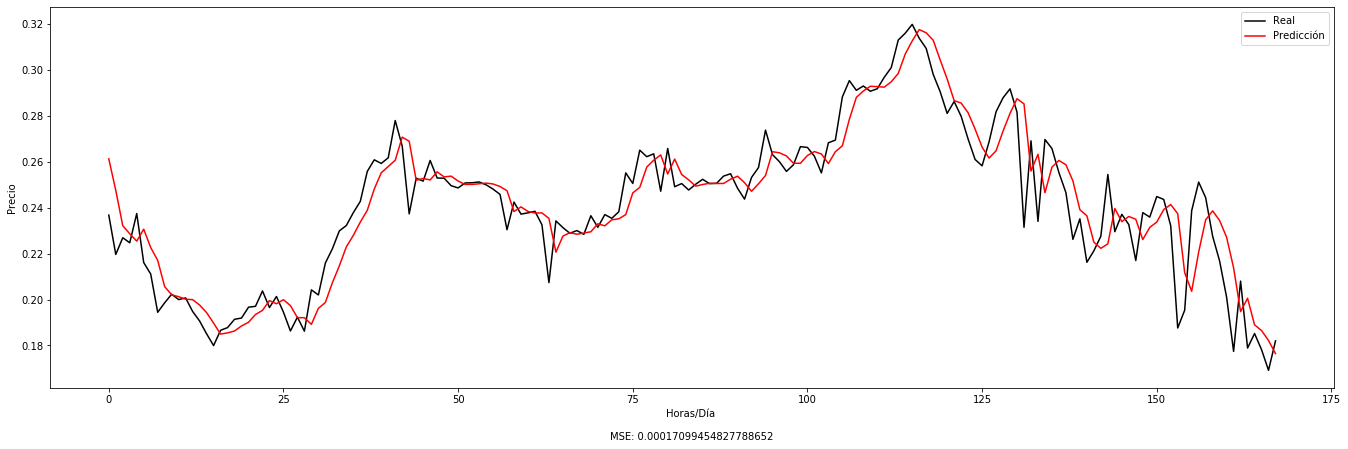

In [372]:
RaizAda1 = adaline(Ret,Tasa,PlotRaiz1["Precio"].to_numpy())
Graficar(RaizAda1[0],RaizAda1[1])

In [373]:
PlotRaiz2 = pd.concat([Precios["Fecha"], Precios.mean(axis=1, numeric_only = True)],axis = 1)
PlotRaiz2 = PlotRaiz.dropna()
PlotRaiz2 = PlotRaiz.reset_index(drop=True)
PlotRaiz2.columns = ["Fecha","Precio"]
PlotRaiz2["Precio"]=(PlotRaiz["Precio"].apply(np.log))
PlotRaiz2["Precio"]=(PlotRaiz["Precio"]-PlotRaiz["Precio"].min())/(PlotRaiz["Precio"].max()-PlotRaiz["Precio"].min())

In [374]:
Prueba2 = [2,3,4,5,6]
Prueba22 = [0.01,0.02,0.03,0.04]

In [377]:
RetardosRaiz2 = SacarRetardo(Prueba2, PlotRaiz2["Precio"].to_numpy())

In [382]:
MejorRetardoRaiz2 = []
for i in RetardosRaiz2:
    MejorRetardoRaiz2.append(metrics.mean_squared_error(i[0],i[1]))
A = MejorRetardoRaiz2.index(min(MejorRetardoRaiz2))
Ret= Prueba2[A]

In [383]:
TasaRaiz2 = SacarTasa(Prueba22,PlotRaiz2["Precio"].to_numpy())

In [384]:
MejorTasaRaiz2 = []
for i in TasaRaiz2:
    MejorTasaRaiz2.append(metrics.mean_squared_error(i[0],i[1]))
B = MejorTasaRaiz2.index(min(MejorTasaRaiz2))
Tasa = Prueba22[B]

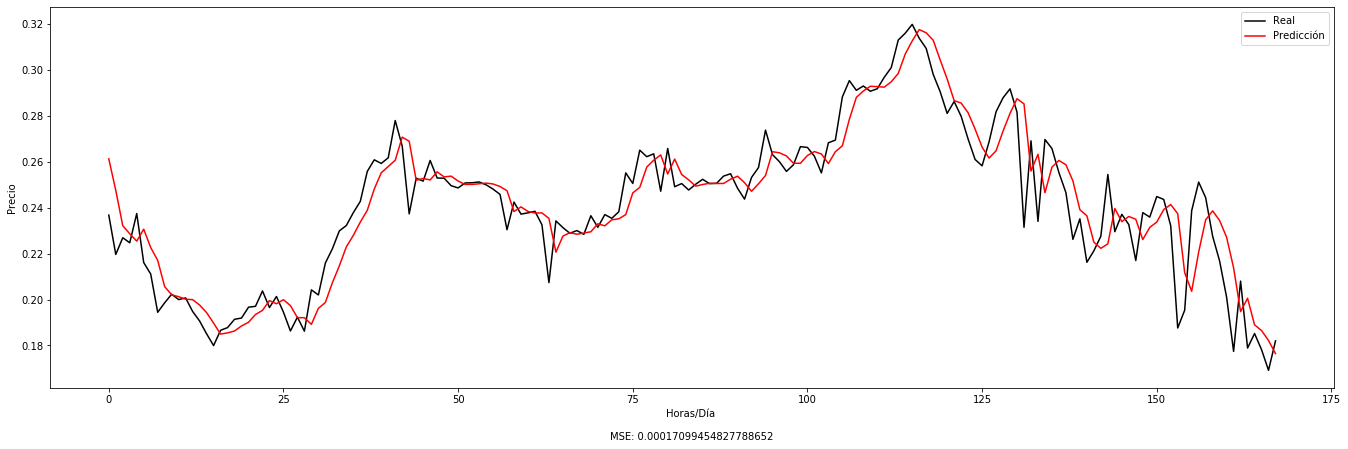

In [385]:
RaizAda2 = adaline(Ret,Tasa,PlotRaiz2["Precio"].to_numpy())
Graficar(RaizAda2[0],RaizAda2[1])